## Tạo ảnh fake từ MNIST với GAN

In [14]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.activation import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook


## Take data from MNIST

In [15]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(f"X_train size{X_train.shape}")
print(f"X_test size{X_test.shape}")
print(f"Y_train size{Y_train.shape}")
print(f"Y_test size{Y_test.shape}")

X_train size(60000, 28, 28)
X_test size(10000, 28, 28)
Y_train size(60000,)
Y_test size(10000,)


## Image Preprocessing

Đưa dữ liệu từ ảnh xám 28*28 về vector với giá trị [0, 1]

In [16]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

## Số chiều noise vector

In [17]:
# Số chiều noise vector
z_dim = 100

In [18]:
#Optimizer
adam = Adam(learning_rate=2e-4, beta_1=0.5)

# Generator model
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
# Vì dữ liệu ảnh MNIST đã chuẩn hóa về [0, 1] nên hàm G khi sinh ảnh ra cũng cần sinh ra ảnh có pixel value trong khoảng [0, 1] => hàm sigmoid được chọn
g.add(Dense(784, activation='sigmoid'))  
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Mô hình Discriminator
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
# Hàm sigmoid cho bài toán binary classification 
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
print(inputs)
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [19]:
# Ham ve loss function

def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10, 8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    
# Ve sample tu generator
def plot_generated(n_ex = 10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off') 
    plt.tight_layout()
    plt.show()

In [20]:
# Lưu giá trị loss và accuracy của Discriminator và Generator
from ctypes import sizeof


losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=10):
    # Tinh so lan chay trong moi epoch
    batchCount = int(X_train.shape[0]/ BATCH_SIZE)
    print('Epochs: ', epochs)
    print('Batch size: ', BATCH_SIZE)
    print(f'Batches per epoch: ', batchCount)
    
    for e in tqdm_notebook(range(1, epochs + 1)):
        if e == 1 or e%plt_frq == 0:
            print("-"*15, f'Epoch {e}', "-"*15)
        for _ in range(batchCount):
            # lay ngau nhien cac anh tu MNIST (Anh that)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # SInh ra noise ngau nhien
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Dung generator sinh ra anh tu noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            
            # Tao label
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9 #gan label = 0.9 cho anh thath tu MNIST vaf 0 cho anh sinh ra boi generator
            
            # Train disciminator
            d.trainable = True
            d_loss = d.train_on_batch(X, y)
            
            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Khi train genrator gan label bangf 1 cho nhung anh sinh ra boi generator => co gang lua Discriminator
            y2 = np.ones(BATCH_SIZE)
            # Khi train Generator thi khong cap nhat he so Discriminator
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
         # Lưu loss function
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Vẽ các số được sinh ra để kiểm tra kết quả
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)
            
            
            

Epochs:  200
Batch size:  128
Batches per epoch:  468


C:\Users\pC\AppData\Local\Temp/ipykernel_8860/159797212.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(1, epochs + 1)):


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
1/1 [==============================] - 0s 256ms/step


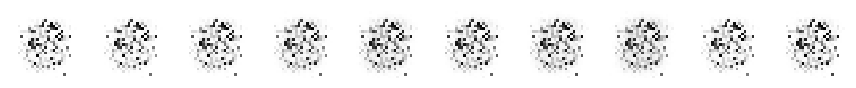

4/4 [==============================] - 0s 8ms/step


In [21]:
train(epochs=200, plt_frq=20, BATCH_SIZE=128)